# Spec2Vec - library matching
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

## Sketch idea:
1000 spectra are seleted and removed from the allGNPS_positive dataset.  
Selection is made based on:  
1. 1000 inchikeys which occur >1 times are selected randomly.
2. For each of those inchikeys one spectrum is selected randomly.

### Importing, initializing...

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

In [3]:
import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile

from scipy import spatial

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [4]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


## Evaluate inchikey occurences

### Get all inchikeys from metadata table. Only look at first 14 characters.

In [6]:
inchikeys_pd = spectra_metadata['inchikey'][spectra_metadata['inchikey'].notnull()]
inchikeys_pd.shape

(50195,)

In [7]:
inchikeys_pd.str[:14][-10:]

90216    CCQDWIRWKWIUKK
90217    RPVIQWDFJPYNJM
90218    BXEZTCOKOLHMKY
90219    BXEZTCOKOLHMKY
90220    PVXPPJIGRGXGCY
90221    ATEFPOUAMCWAQS
90222    ILEDWLMCKZNDJK
90223    ILEDWLMCKZNDJK
90224    NCJNNMWJQIKYLO
90225    LNCLTICCQWMCNS
Name: inchikey, dtype: object

### Get number of occurences for all inchikey (first 14 letters)

In [8]:
inchikeys_pd.str[:14].value_counts()[:10]

PFTAWBLQPZVEMU    63
KMPWYEUPVWOPIM    57
MPDGHEJMBKOTSU    49
DFPMSGMNTNDNHN    46
TZBJGXHYKVUXJN    46
OXGUCUVFOIWWQJ    45
LJOQGZACKSYWCH    45
RYYVLZVUVIJVGH    45
HPNSFSBZBAHARI    43
QEVHRUUCFGRFIF    43
Name: inchikey, dtype: int64

### Plot histogram of inchikey occurences

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

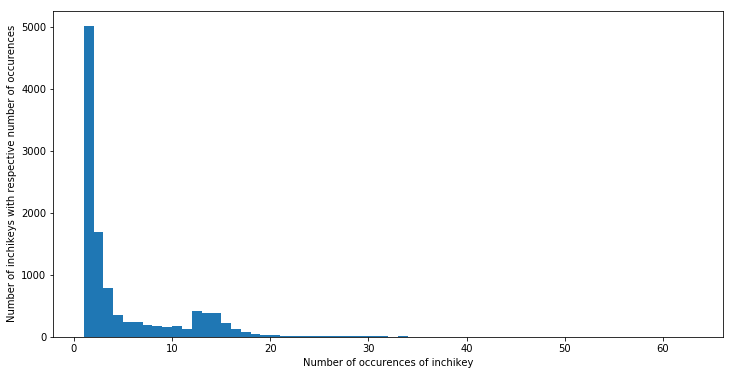

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), 62)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Select spectra to simulate libarary matching

In [10]:
import pandas as pd

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values > 1])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,PFTAWBLQPZVEMU,63
1,KMPWYEUPVWOPIM,57
2,MPDGHEJMBKOTSU,49
4,TZBJGXHYKVUXJN,46
3,DFPMSGMNTNDNHN,46
7,RYYVLZVUVIJVGH,45
5,OXGUCUVFOIWWQJ,45
6,LJOQGZACKSYWCH,45
11,REFJWTPEDVJJIY,43
9,QEVHRUUCFGRFIF,43


In [11]:
print("Number of spectra with inchikeys that exist >1 times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >1 times: 5998


### Randomly select 1000 inchikeys that exist >1 times in the dataset

In [12]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[  84 2409 4996  346   79  994 4951 4078 3940 1870 4463  752 1747 3651
 1235 5426 3161 5606 3307 3194 5365 3235  530 1580 3921]


array(['COLNVLDHVKWLRT', 'NOCJXYPHIIZEHN', 'PILWRMVFWRVMAP',
       'TVKGYMYAOVADOP', 'YFGYUFNIOHWBOB', 'DHVXMTMJTVCPBB',
       'QAUDHOGPLBDVAX', 'HUSISCNTLUEZCN', 'LVTJOONKWUXEFR',
       'XDRYMKDFEDOLFX', 'XTQOUVPIWQGVEJ', 'SUAPQGLGNKUSLY',
       'HGVAHYJMDVROLE', 'VJLVPUFVTPJHDI', 'NRQCIBSGSINRCF',
       'JCHUCLMYSKXMOY', 'AEMOLEFTQBMNLQ', 'GQZDMSIXKBSDIE',
       'OTCCIMWXFLJLIA', 'YFGBQHOOROIVKG', 'KBJKWXDTUOJWAI',
       'VCKUSRYTPJJLNI', 'OJDSCNUKKOKOQJ', 'PYMYPHUHKUWMLA',
       'MDJRZSNPHZEMJH'], dtype=object)

### Randomly pick one spectra for each of the chosen inchikeys

In [13]:
selected_spectra = []

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [14]:
# Show gnps IDs for selected spectra
spectra_metadata["gnps_ID"][selected_spectra][:10]

24236    CCMSLIB00000205644
33851    CCMSLIB00000569056
12382    CCMSLIB00000853997
39733    CCMSLIB00004696408
26281    CCMSLIB00000210444
43418    CCMSLIB00004701023
8396     CCMSLIB00000846515
11820    CCMSLIB00000852861
13423    CCMSLIB00000856134
30103    CCMSLIB00000221327
Name: gnps_ID, dtype: object

## Train new Spec2Vec model on dataset without the selected spectra

In [ ]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_librarymatching_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)
print("Learning rate droped from", MS_library.model_word2vec.alpha, "to", MS_library.model_word2vec.min_alpha_yet_reached)

### or load already trained model...

In [17]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_librarymatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)


Modified corpus consists of 89726 documents.
Preprocess documents...
Number of unique words:  145580
Load stored word2vec model ...


## Calculate Spec2Vec spectra vectors for all library spectra

In [18]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  89226  of  89226  documents.89226  documents.  of  89226  documents. 3840  of  89226  documents. documents.  documents. 5890  of  89226  documents.  documents. documents.89226  documents. of  89226  documents. 89226  documents. documents. of  89226  documents.89226  documents. 89226  documents.89226  documents.  documents. Calculated centroid vectors for  17100  of  89226  documents.89226  documents.89226  documents. documents.  of  89226  documents. 89226  documents.  of  89226  documents. Calculated centroid vectors for  23360  of  89226  documents. of  89226  documents. of  89226  documents. of  89226  documents.  documents. of  89226  documents. 31250  of  89226  documents. of  89226  documents. 89226  documents. Calculated centroid vectors for  34670  of  89226  documents. documents. of  89226  documents. 89226  documents.  documents. documents.89226  documents.89226  do

---
### Save MS_library object with S2V model and calculated spectra vectors
This will save the entire SimilarityMeasures class object: MS_library.

In [20]:
MS_library.save(PATH_COMPUTED + 'MS_library_matching_unkown_spectra_191127.obj')

---
### Or load MS_library object if already processed before...

In [17]:
MS_library = SimilarityMeasures([])
MS_library.load(PATH_COMPUTED + 'MS_library_matching_unkown_spectra_191127.obj')

### Create library data by removing selected spectra

In [18]:
library_spectra_IDs = [x for x in range(len(spectra)) if x not in selected_spectra]
library_spectra_metadata = spectra_metadata.loc[library_spectra_IDs]

library_spectra_metadata.shape

(89226, 10)

In [19]:
spectra_unknown = [spectra[x] for x in selected_spectra]
spectra_library = [spectra[x] for x in range(len(spectra)) if x not in selected_spectra]
print("Number of 'unknown' spectra:", len(spectra_unknown))
print("Number of reference spectra in library:", len(spectra_library))

Number of 'unknown' spectra: 1000
Number of reference spectra in library: 89226


### Define function for library matching (to be moved to core code...)

In [15]:
def library_matching(spectra_query, 
                     spectra_library,
                     library_spectra_metadata, 
                     MS_library, 
                     top_n = 10,
                     mz_ppm = 10,
                     spectra_vectors = None,
                     ignore_non_annotated = True,
                     cosine_tol = 0.005):
    """
    Function to select potential spectra matches.
    Suitable candidates will be selected by 1) top_n Spec2Vec similarity, and 2) same precursor mass 
    (within given mz_ppm tolerance(s)). 
    For later matching routines, additional scores (cosine, modified cosine) are added as well.
    
    Args:
    --------
    """
    
    # Check input data
    if len(spectra_library) != library_spectra_metadata.shape[0]:
        print("Warning! Library spectra metadata input does not match given library spectra.")
    if len(spectra_library) != len(MS_library.corpus):
        print("Warning! Library spectra input does not match dimension of given MS_library object.")
    if MS_library.vectors_centroid.shape[0] != library_spectra_metadata.shape[0]:
        print("Warning! Number of found Spec2Vec spectral vectors does not agree with library metadata dimension.")
    if spectra_vectors is None:
        print("No Spec2Vec spectra vectors found for query data. Please do so using the vectorize_spectra() function")

    
    # Initializations
    found_matches = []
    S2V_matches = []
    
    if ignore_non_annotated:
        # Get array of all IDs for spectra with smiles
        annotated_spectra_IDs = np.where(library_spectra_metadata['smiles'].isna().values == False)[0]
    
    # --------------------------------------------------------------------------
    # 1. Search for top-n Spec2Vec matches -------------------------------------
    # --------------------------------------------------------------------------
    
    #Check if Spec2Vec vectors are present for library
    if len(MS_library.vectors_centroid) == 0:
        print("Apparently Spec2Vec spectra vectors have not yet been derived for library data.")
        print("Spec2Vec spectra vectors will be calculated using default parameters.")
        MS_library.get_vectors_centroid(method = 'ignore', 
                                         extra_weights = None, 
                                         tfidf_weighted = False, 
                                         weight_method = 'sqrt', 
                                         tfidf_model = None,
                                         extra_epochs = 1)
    else:
        print("Spec2Vec spectra vectors found for library data.")

    if ignore_non_annotated:
        library_vectors = MS_library.vectors_centroid[annotated_spectra_IDs]
    else:
        library_vectors = MS_library.vectors_centroid
    M_spec2vec_similairies = 1 - spatial.distance.cdist(library_vectors, spectra_vectors, 'cosine')

    # Select top_n similarity values:
    Top_n = np.argpartition(M_spec2vec_similairies, -top_n, axis=0)[-top_n:,:]

    # Sort selected values by order
    for i in range(len(spectra_query)):
        Top_n_sorted = Top_n[:,i][np.argsort(M_spec2vec_similairies[Top_n[:,i],i])][::-1]
        if ignore_non_annotated:
            Top_n_corrected_IDs = annotated_spectra_IDs[Top_n_sorted]
        else:
            Top_n_corrected_IDs = Top_n_sorted

        S2V_match = list(zip(Top_n_corrected_IDs, M_spec2vec_similairies[Top_n_sorted,i]))
        S2V_matches.append(S2V_match)
                  
    # --------------------------------------------------------------------------
    # 2. Search for precursor mz based matches --------------------------------
    # --------------------------------------------------------------------------
    if ignore_non_annotated:
        library_masses = library_spectra_metadata['precursor_mz'].values[annotated_spectra_IDs]
    else:
        library_masses = library_spectra_metadata['precursor_mz'].values
        
    if not isinstance(mz_ppm, list):
        mz_ppm = [mz_ppm]
    mz_ppm = sorted(mz_ppm)[::-1]
    
    mass_matches_ppms = []
    for ppm in mz_ppm:
        library_masses_tol = library_masses * ppm/1e6
        mass_matches = []
            
        # Get precursor mz for query spectra
        precursor_mz_query = []

        for spec in spectra_query:
            mass = spec.precursor_mz
            mass_match = np.where(((library_masses + library_masses_tol) > mass) & 
                                  ((library_masses - library_masses_tol) < mass))[0]
            if ignore_non_annotated:
                mass_matches.append(annotated_spectra_IDs[mass_match])
            else:
                mass_matches.append(mass_match)
        mass_matches_ppms.append(mass_matches)
    
    # --------------------------------------------------------------------------
    # 3. Combine found matches -------------------------------------------------
    # --------------------------------------------------------------------------
    for i in range(len(spectra_query)):
        IDs = list(mass_matches_ppms[0][i])
        mass_match_lst = len(mass_matches_ppms[0][i]) * [1]
        s2v_match_lst = len(mass_matches_ppms[0][i]) * [0]
        
        # Add Spec2Vec top_n matches to list
        a, _ = list(zip(*S2V_matches[i]))
        for match in a:
            if match in IDs:
                s2v_match_lst[IDs.index(match)] = 1
            else:
                IDs.append(match)
                mass_match_lst.append(0)
                s2v_match_lst.append(1)
                
        # Add Spec2Vec scores for all entries
        # And calculate if found inchikey is a match
        inchikey_match = []
        s2v_score_lst = []
        for m, idx in enumerate(IDs):
            #if s2v_match_lst[m] == 0:
            if ignore_non_annotated:
                idx_uncorrected = int(np.where(annotated_spectra_IDs == idx)[0])
                s2v_score_lst.append(M_spec2vec_similairies[idx_uncorrected,i])
            else:
                s2v_score_lst.append(M_spec2vec_similairies[idx,i])
                
            inchikey_match.append(1 * (spectra_library[idx].inchikey[:14] == spectra_query[i].inchikey[:14]))
        matches_df = pd.DataFrame(list(zip(IDs, mass_match_lst, s2v_match_lst, s2v_score_lst, inchikey_match)),
                                       columns = ['spectra_ID', 
                                                  'mass_match'+ str(int(mz_ppm[0])) + 'ppm', 
                                                  'S2V_top_n', 'S2V_similarity', 'inchikey_match'])
        # Add mass matches from other ppms (if given)
        for m, ppm in enumerate(mz_ppm[1:]):
            col_name = 'mass_match_' + str(int(ppm)) + 'ppm'
            matches_df[col_name] = 0
            matches_df.loc[matches_df['spectra_ID'].isin(mass_matches_ppms[m+1][i]), col_name] = 1        
        
        found_matches.append(matches_df) 
    
    # --------------------------------------------------------------------------
    # 4. Add additonal similarity measures (cosine + mod.cosine) ---------------
    # --------------------------------------------------------------------------   
    for i in range(len(spectra_query)): 
        cosine_scores = []
        for j in found_matches[i]['spectra_ID']:
            cosine_score = cosine_check(spectra_query[i],
                                        spectra_library[j],
                                        tol = cosine_tol,
                                        mod_cosine = False)
            cosine_scores.append(cosine_score)
        a, b = list(zip(*cosine_scores))
        found_matches[i]['cosine_score'] = a
        found_matches[i]['cosine_matches'] = b
                
    for i in range(len(spectra_query)): 
        cosine_scores = []
        for j in found_matches[i]['spectra_ID']:
            cosine_score = cosine_check(spectra_query[i],
                                        spectra_library[j],
                                        tol = cosine_tol,
                                        mod_cosine = True)
            cosine_scores.append(cosine_score)
        a, b = list(zip(*cosine_scores))
        found_matches[i]['modcosine_score'] = a
        found_matches[i]['modcosine_matches'] = b
                
    return found_matches


def cosine_check(spectra1,
                 spectra2,
                 tol = 0.005,
                 mod_cosine = False):

    if mod_cosine:
        mass_shift = spectra1.parent_mz - spectra2.parent_mz
    else:
        mass_shift = None
    spec1 = np.array(spectra1.peaks, dtype=float)
    spec2 = np.array(spectra2.peaks, dtype=float)
    cosine_score = MS_sim_classic.cosine_score_greedy(spec1, 
                                                    spec2,
                                                    mass_shift = mass_shift,
                                                    tol = tol, 
                                                    min_intens = 0,
                                                    use_numba = True)
    return (cosine_score[0], len(cosine_score[1]))
        

### Calculate Spec2Vec spectra vector for query spectra

In [20]:
spectra_vectors = MS_functions.vectorize_spectra(spectra_unknown,
                                                  MS_library,
                                                  num_decimals = 2,
                                                  min_loss = 5.0, 
                                                  max_loss = 500.0,
                                                  peak_loss_words = ['peak_', 'loss_'],
                                                  weighting_power = 0.5)

  Created documents for  1000  of  1000  spectra.
 ----------------------------------------
Not all 'words' of the given documents are present in the trained word2vec model!
23  out of  58468  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
----- Deriving Spec2Vec spectra vectors -----
  Calculated Spec2Vec spectra vectors for  1000  of  1000  documents.50  of  1000  documents. 1000  documents.1000  documents. of  1000  documents.

---
## Search for spectra matches in library
This search will select all (annotated) spectra in the library for: 
+ same parent mass (within 10ppm)
+ top-n (here: top-10) Spec2Vec similarity scores

Then, between the query spectra and the found library spectra we also calculate:
+ cosine score (tol = 0.05)
+ modified cosine score (tol = 0.05)

In [21]:
found_matches = library_matching(spectra_unknown, 
                                  spectra_library,
                                  library_spectra_metadata, 
                                  MS_library, 
                                  top_n = 10,
                                  mz_ppm = [2, 10, 50],
                                  spectra_vectors = spectra_vectors,
                                  ignore_non_annotated = True,
                                  cosine_tol = 0.05)

Spec2Vec spectra vectors found for library data.


In [22]:
print("Searched matches for", len(found_matches), "query spectra.")

Searched matches for 1000 query spectra.


## Inspect detected potential matches:

In [23]:
found_matches[12]

,spectra_ID,mass_match50ppm,S2V_top_n,S2V_similarity,inchikey_match,mass_match_10ppm,mass_match_2ppm,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,8175,1,0,-0.000192,0,1,1,0.000353,5,0.000353,5
1,23318,1,0,0.067495,0,0,0,0.000188,1,0.000224,2
2,23320,1,0,0.059382,0,0,0,0.000644,1,0.000713,2
3,23326,1,0,0.087791,0,0,0,0.007117,3,0.007997,4
4,48044,1,0,0.774591,1,1,1,0.835294,75,0.835294,75
5,48045,1,0,0.587870,1,1,1,0.525393,59,0.525393,59
6,54058,1,0,0.774712,0,0,0,0.764032,55,0.764032,55
7,54059,1,1,0.830396,0,0,0,0.949104,56,0.949104,56
8,54060,1,0,0.596053,0,0,0,0.499366,50,0.499366,50
9,54996,0,1,0.834848,0,0,0,0.934928,47,0.936301,50


In [395]:
ID = 3
idx = found_matches[ID][(found_matches[ID]['mass_match'] == 1)]['spectra_ID'].values
inchikeys14 = pd.Series(library_spectra_metadata.iloc[idx]['inchikey'].str[:14])
inchikeys14.value_counts().index[0]

'TVKGYMYAOVADOP'

## More extensive run through different scenarios:

In [24]:
test0_true_false = []
test1_true_false = []
test2_true_false = []
test3_true_false = []
test4_true_false = []

for ID in range(len(spectra_unknown)):
    
    # Scenario 0: mass + sort by frequency
    df_select = found_matches[ID][found_matches[ID]['mass_match_10ppm'] == 1]
    if df_select.shape[0] > 0:
        # Find most frequent inchikey among mass matches
        idx = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1)]['spectra_ID'].values
        inchikeys14 = pd.Series(library_spectra_metadata.iloc[idx]['inchikey'].str[:14])
        best_bet = 1 * (inchikeys14.value_counts().index[0] == spectra_unknown[ID].inchikey[:14])        
    else:
        best_bet = -1 # meaning: not found
    test0_true_false.append(best_bet)
    
    # Scenario 1: mass + sort by mod.cos
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = -1 # meaning: not found
    test1_true_false.append(best_bet)
    
    # Scenario 2: mass + sort by Spec2Vec
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = -1 # meaning: not found
    test2_true_false.append(best_bet)
    
    # Scenario 3: mass + Spec2Vec + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1) 
                                  & (found_matches[ID]['S2V_top_n'] > 0)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = -1 # meaning: not found
    test3_true_false.append(best_bet)  
    
    # Scenario 4: mass + Spec2Vec + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1) 
                                  & ((found_matches[ID]['S2V_similarity'] > 0.5) |(found_matches[ID]['modcosine_score'] > 0.5))]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        df_select = found_matches[ID][(found_matches[ID]['S2V_top_n'] > 0) 
                              & (found_matches[ID]['S2V_similarity'] > 0.8)]
        if df_select.shape[0] > 0:
            best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
        else:
            best_bet = -1 # meaning: not found

    test4_true_false.append(best_bet)

# Make arrays from lists:
test0_arr = np.array(test0_true_false)
test1_arr = np.array(test1_true_false)
test2_arr = np.array(test2_true_false)
test3_arr = np.array(test3_true_false)
test4_arr = np.array(test4_true_false)

In [25]:
print("Scenario 0 found matches:", np.sum(test0_arr == 1), " --- nothing detected for: ", np.sum(test0_arr == -1))
print("Scenario 1 found matches:", np.sum(test1_arr == 1), " --- nothing detected for: ", np.sum(test1_arr == -1))
print("Scenario 2 found matches:", np.sum(test2_arr == 1), " --- nothing detected for: ", np.sum(test2_arr == -1))
print("Scenario 3 found matches:", np.sum(test3_arr == 1), " --- nothing detected for: ", np.sum(test3_arr == -1))
print("Scenario 4 found matches:", np.sum(test4_arr == 1), " --- nothing detected for: ", np.sum(test4_arr == -1))

Scenario 0 found matches: 398  --- nothing detected for:  92
Scenario 1 found matches: 594  --- nothing detected for:  92
Scenario 2 found matches: 623  --- nothing detected for:  92
Scenario 3 found matches: 468  --- nothing detected for:  422
Scenario 4 found matches: 602  --- nothing detected for:  218


## Plot key results
Compare different search procedures by plotting the true matches (unknown spectra matched to correct inchikey), the false matches (matched to other than the correct inchikey), or no matches found (method could not find a suitable match).

Text(0.5, 1.0, 'Spectral library matching comparison (>1 matching inchikey in library)')

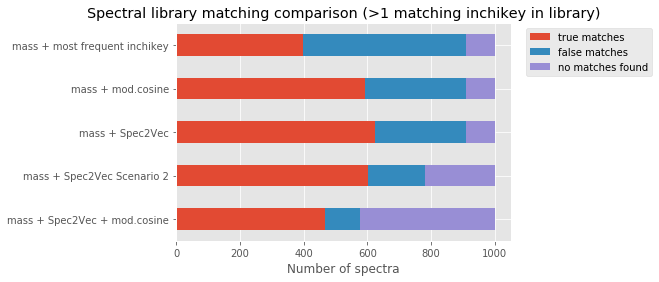

In [26]:
plt.style.use('ggplot')

ylabels = ['mass + most frequent inchikey',
          'mass + mod.cosine', 
          'mass + Spec2Vec',
          'mass + Spec2Vec + mod.cosine',
          'mass + Spec2Vec Scenario 2']#,'mass + Spec2Vec + mod.cosine -> mass + Spec2Vec (2 steps)']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test0_arr == 1), np.sum(test0_arr == 0), np.sum(test0_arr == -1)],
                [np.sum(test1_arr == 1), np.sum(test1_arr == 0), np.sum(test1_arr == -1)],
               [np.sum(test2_arr == 1), np.sum(test2_arr == 0), np.sum(test2_arr == -1)],
               [np.sum(test3_arr == 1), np.sum(test3_arr == 0), np.sum(test3_arr == -1)],
                [np.sum(test4_arr == 1), np.sum(test4_arr == 0), np.sum(test4_arr == -1)]])
  
dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison (>1 matching inchikey in library)')

In [59]:
dataframe

,true matches,false matches,no matches found
mass + most frequent inchikey,397,511,92
mass + mod.cosine,594,314,92
mass + Spec2Vec,623,285,92
mass + Spec2Vec + mod.cosine,468,110,422
mass + Spec2Vec Scenario 2,602,180,218


# Applying classical machine-learning to library matching

## 1. Linear regression model
### Prepare trainings data

In [27]:
X_data = found_matches[0].drop(columns= ['spectra_ID', 'inchikey_match'])
y_data = found_matches[0]['inchikey_match']
for matches_pd in found_matches[1:]:
    X_data = pd.concat([X_data, matches_pd.drop(columns= ['spectra_ID', 'inchikey_match'])], axis=0)
    y_data = pd.concat([y_data, matches_pd['inchikey_match']], axis=0)

X_data.shape, y_data.shape

((25758, 9), (25758,))

In [28]:
X_data.head()

,mass_match50ppm,S2V_top_n,S2V_similarity,mass_match_10ppm,mass_match_2ppm,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,1,0,-0.032902,1,1,0.322122,1,0.322122,1
1,1,1,0.968521,0,0,0.995873,5,0.995873,5
2,1,0,0.674959,1,1,0.655109,5,0.655109,5
3,1,1,0.912094,1,1,0.985430,5,0.985430,5
4,1,0,0.052670,1,0,0.985079,1,0.985079,1


In [29]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [31]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
y_pred = regressor.predict(X_test)

In [33]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df[:10]

,Actual,Predicted
3,0,0.012017
41,0,-0.018274
12,0,0.084194
7,0,0.135964
11,0,0.056774
0,0,0.003939
12,0,-0.025573
19,0,-0.003655
9,0,-0.021697
35,0,0.208355


In [35]:
print(np.sum((df.Actual == 0) * (df.Predicted < 0.5)), 
    np.sum((df.Actual == 1) * (df.Predicted >= 0.5)), 
    np.sum((df.Actual == 0) * (df.Predicted >= 0.5)), 
    np.sum((df.Actual == 1) * (df.Predicted < 0.5)))

4444 297 129 282


In [36]:
coeff_df = pd.DataFrame(regressor.coef_, X_data.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
mass_match50ppm,0.403333
S2V_top_n,0.319750
S2V_similarity,0.182197
mass_match_10ppm,0.033506
mass_match_2ppm,0.155313
cosine_score,0.095087
cosine_matches,-0.000157
modcosine_score,0.003636
modcosine_matches,0.000266


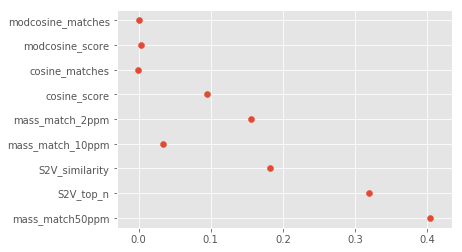

In [37]:
plt.scatter(x=regressor.coef_, y=X_data.columns)

In [55]:
X_data_effect = X_data.copy()
X_data_effect.iloc[:,:] = X_data.iloc[:,:] * regressor.coef_

## Effect plot

(-0.1, 0.5)

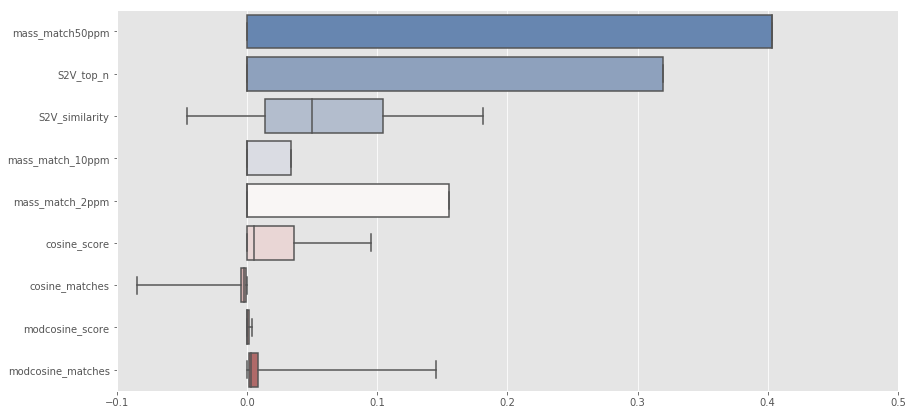

In [57]:
import seaborn as sns
plt.figure(figsize=(14,7))
sns.boxplot(data=X_data_effect,
            whis="range", palette="vlag", orient='h')
plt.xlim(-0.1,0.5)

## 2. Decision tree

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
ML_model_DT = DecisionTreeClassifier(random_state=0)#, max_depth = 10)

#cross_val_score(clf, iris.data, iris.target, cv=10)

In [75]:
ML_model_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [76]:
y_pred = ML_model_DT.predict(X_test)

In [77]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print(np.sum((df.Actual == 0) * (df.Predicted == 0)), 
    np.sum((df.Actual == 1) * (df.Predicted == 1)), 
    np.sum((df.Actual == 0) * (df.Predicted == 1)), 
    np.sum((df.Actual == 1) * (df.Predicted == 0)))

4249 326 324 253


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [78]:
feature_importance = pd.DataFrame(100*np.round(ML_model_DT.feature_importances_,4), X_data.columns, columns=['Feature importance'])  
feature_importance

,Feature importance
mass_match50ppm,0.10
S2V_top_n,11.63
S2V_similarity,24.17
mass_match_10ppm,1.53
mass_match_2ppm,18.82
cosine_score,14.78
cosine_matches,7.98
modcosine_score,13.60
modcosine_matches,7.38


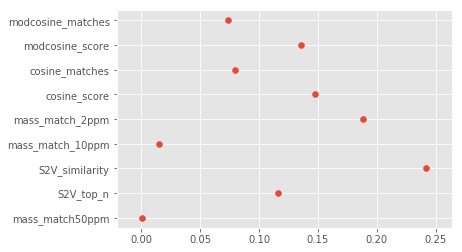

In [79]:
plt.scatter(x=ML_model_DT.feature_importances_, y=X_data.columns)

In [62]:
# import export_graphviz 
from sklearn.tree import export_graphviz  
  
# export the decision tree to a tree.dot file 
# for visualizing the plot elsewhere
export_graphviz(ML_model_DT, max_depth = 3, out_file ='tree3.dot', feature_names = X_data.columns)  

# --> than go to http://www.webgraphviz.com/ and add tree.dot file

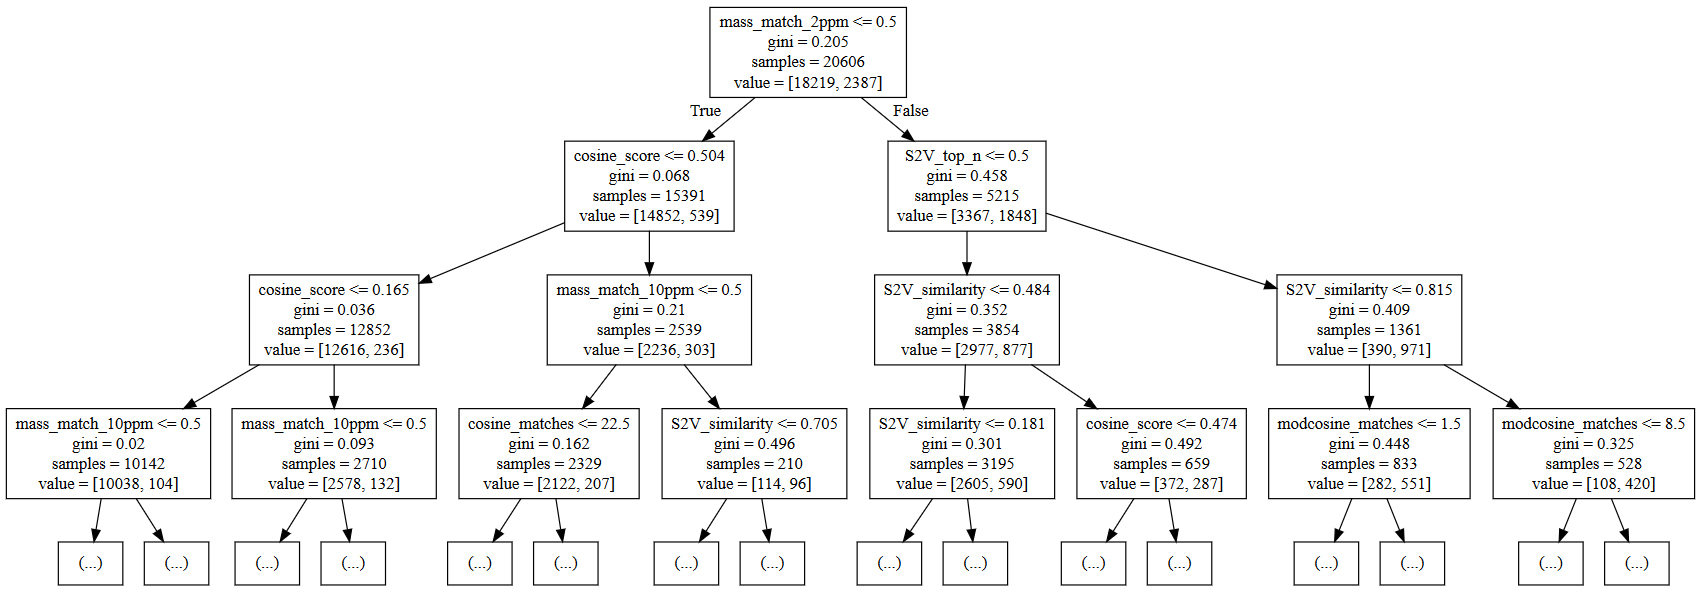

In [63]:
from IPython.display import Image
Image("Screenshot_2019-12-02 Webgraphviz.png")

In [80]:
testLR_true_false = [] # linear regression
testML_true_false = []

for ID in range(len(spectra_unknown)):
    
    # Scenario ML - linear regression
    predictions = regressor.predict(found_matches[ID].drop(columns= ['spectra_ID', 'inchikey_match']))
    spectraIDs = found_matches[ID]['spectra_ID'][predictions.argmax()]
    #spectraIDs = found_matches[ID][IDs == 1]['spectra_ID'].values.tolist()
    inchikeys14 = library_spectra_metadata.iloc[spectraIDs]['inchikey'][:14]
    if len(inchikeys14) > 0:
        best_bet = 1 * (inchikeys14 == spectra_unknown[ID].inchikey[:14])        
    else:
        best_bet = -1 # meaning: not found

    testLR_true_false.append(best_bet)
    
    # Scenario ML - decision tree
    IDs = ML_model_DT.predict(found_matches[ID].drop(columns= ['spectra_ID', 'inchikey_match']))
    spectraIDs = found_matches[ID][IDs == 1]['spectra_ID'].values.tolist()
    inchikeys14 = pd.Series(library_spectra_metadata.iloc[spectraIDs]['inchikey'].str[:14])
    if inchikeys14.shape[0] > 0:
        best_bet = 1 * (inchikeys14.value_counts().index[0] == spectra_unknown[ID].inchikey[:14])        
    else:
        best_bet = -1 # meaning: not found

    testML_true_false.append(best_bet)
    
# Make arrays from lists:
testLR_arr = np.array(testLR_true_false)
testML_arr = np.array(testML_true_false)

In [81]:
print("Linear regression found matches:", np.sum(testLR_arr == 1), " --- nothing detected for: ", np.sum(testLR_arr == -1))
print("ML found matches:", np.sum(testML_arr == 1), " --- nothing detected for: ", np.sum(testML_arr == -1))

Linear regression found matches: 660  --- nothing detected for:  0
ML found matches: 767  --- nothing detected for:  163


Text(0.5, 1.0, 'Spectral library matching comparison (>1 matching inchikey in library)')

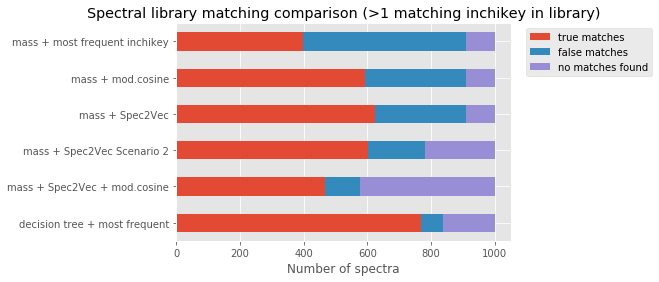

In [82]:
plt.style.use('ggplot')

ylabels = ['mass + most frequent inchikey',
          'mass + mod.cosine', 
          'mass + Spec2Vec',
          'mass + Spec2Vec + mod.cosine',
          'mass + Spec2Vec Scenario 2',
           #'linear regression model',
          'decision tree + most frequent']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test0_arr == 1), np.sum(test0_arr == 0), np.sum(test0_arr == -1)],
                [np.sum(test1_arr == 1), np.sum(test1_arr == 0), np.sum(test1_arr == -1)],
               [np.sum(test2_arr == 1), np.sum(test2_arr == 0), np.sum(test2_arr == -1)],
               [np.sum(test3_arr == 1), np.sum(test3_arr == 0), np.sum(test3_arr == -1)],
                [np.sum(test4_arr == 1), np.sum(test4_arr == 0), np.sum(test4_arr == -1)],
                 #[np.sum(testLR_arr == 1), np.sum(testLR_arr == 0), np.sum(testLR_arr == -1)],
                 [np.sum(testML_arr == 1), np.sum(testML_arr == 0), np.sum(testML_arr == -1)]])
  
dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison (>1 matching inchikey in library)')

# Compare to case when multiple copies of the same inchikey are present in library

In [83]:
min_occurences = 5

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_occurences])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.tail(5)

,inchikey14,occurences
2956,ALGDHWVALRSLBT,5
3122,AKGWUHIOEVNNPC,5
3015,AFSDNFLWKVMVRB,5
2964,AEMOLEFTQBMNLQ,5
2993,ACGDKVXYNVEAGU,5


In [84]:
print("Number of spectra with inchikeys that exist >=", min_occurences, "times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >= 5 times: 3163


### Randomly select 1000 inchikeys that exist >=5 times in the dataset

In [85]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[2755  346  170  354 1556  761  408 1011  557 2726 3121 2875 2215 2847
 2838 2418 2710 2689 1672 1330 1264 1820  450  927  463]


array(['QIGBRXMKCJKVMJ', 'TVKGYMYAOVADOP', 'DYKFCLLONBREIL',
       'RONZAEMNMFQXRA', 'RCKDDMWGRIYLCN', 'RYVGCUJETSKZDU',
       'GPFVBJYXFRIOFB', 'CDYGRHOHQUXDMN', 'LOFYFDPXORJJEE',
       'UJVLDDZCTMKXJK', 'DHWRNDJOGMTCPB', 'DZVIFFMYEULLBY',
       'PVXVWWANJIWJOO', 'HPZJMUBDEAMBFI', 'ITVGXXMINPYUHD',
       'MHGMSAFPNAKIRZ', 'VLGUKBMOYDQZNE', 'XQVWYOYUZDUNRW',
       'LJKAKWDUZRJNPJ', 'IHGAMZBDEOTTEW', 'MHVJRKBZMUDEEV',
       'CVXGFPPAIUELDV', 'XZZNDPSIHUTMOC', 'IOMBMOCSWVAYQU',
       'WGLRJONCGNNMKL'], dtype=object)

### Randomly pick one spectra for each of the chosen inchikeys

In [86]:
selected_spectra = []

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [87]:
# Show gnps IDs for selected spectra
spectra_metadata["gnps_ID"][selected_spectra][:10]

36190    CCMSLIB00004691682
39731    CCMSLIB00004696406
32682    CCMSLIB00000567060
33565    CCMSLIB00000568578
49155    CCMSLIB00004708987
42559    CCMSLIB00004699948
41802    CCMSLIB00004699002
51066    CCMSLIB00004711375
48929    CCMSLIB00004708704
32139    CCMSLIB00000564922
Name: gnps_ID, dtype: object

## Train new Spec2Vec model on dataset without the selected spectra

In [173]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_libmatching_occ5_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)
print("Learning rate droped from", MS_library.model_word2vec.alpha, "to", MS_library.model_word2vec.min_alpha_yet_reached)

Modified corpus consists of 89226 documents.
Preprocess documents...
Number of unique words:  145575
No saved word2vec model found with given filename!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 6903055.5
 Epoch 2 of 15.Change in loss after epoch 2: 5018393.5
 Epoch 3 of 15.Change in loss after epoch 3: 4603321.0
 Epoch 4 of 15.Change in loss after epoch 4: 3739040.0
 Epoch 5 of 15.Change in loss after epoch 5: 3354822.0
 Epoch 6 of 15.Change in loss after epoch 6: 3342098.0
 Epoch 7 of 15.Change in loss after epoch 7: 3328456.0
 Epoch 8 of 15.Change in loss after epoch 8: 3245080.0
 Epoch 9 of 15.Change in loss after epoch 9: 1897702.0
 Epoch 10 of 15.Change in loss after epoch 10: 1907112.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_libmatching_occ5_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1851244.0
 E

### Calculate Spec2Vec spectra vectors for all library spectra

In [174]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 0)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  89226  of  89226  documents.89226  documents.  documents.  documents. 89226  documents.  of  89226  documents. of  89226  documents. of  89226  documents. documents. 89226  documents.89226  documents.  documents. of  89226  documents. 89226  documents. documents.89226  documents.89226  documents. of  89226  documents. documents.19280  of  89226  documents.  documents. of  89226  documents. documents. documents.  documents. documents.  documents. 89226  documents. 89226  documents. documents.  documents. documents. documents.  documents.89226  documents.89226  documents.  documents.  of  89226  documents. 89226  documents. of  89226  documents. of  89226  documents. of  89226  documents.  documents.  of  89226  documents. 89226  documents.47190  of  89226  documents. 89226  documents. documents.89226  documents. documents.  of  89226  documents.  of  89226  documents.89226  do

---
### Save MS_library object with S2V model and calculated spectra vectors
This will save the entire SimilarityMeasures class object: MS_library.

In [175]:
MS_library.save(PATH_COMPUTED + 'MS_library_matching_unkown_spectra_191129.obj')

---
### Or load MS_library object if already processed before...

In [88]:
MS_library = SimilarityMeasures([])
MS_library.load(PATH_COMPUTED + 'MS_library_matching_unkown_spectra_191129.obj')

### Create library data by removing selected spectra

In [89]:
library_spectra_IDs = [x for x in range(len(spectra)) if x not in selected_spectra]
library_spectra_metadata = spectra_metadata.loc[library_spectra_IDs]

library_spectra_metadata.shape

(89226, 10)

In [90]:
spectra_unknown = [spectra[x] for x in selected_spectra]
spectra_library = [spectra[x] for x in range(len(spectra)) if x not in selected_spectra]
print("Number of 'unknown' spectra:", len(spectra_unknown))
print("Number of reference spectra in library:", len(spectra_library))

Number of 'unknown' spectra: 1000
Number of reference spectra in library: 89226


### Calculate Spec2Vec spectra vector for query spectra

In [91]:
spectra_vectors = MS_functions.vectorize_spectra(spectra_unknown,
                                                  MS_library,
                                                  num_decimals = 2,
                                                  min_loss = 5.0, 
                                                  max_loss = 500.0,
                                                  peak_loss_words = ['peak_', 'loss_'],
                                                  weighting_power = 0.5)

  Created documents for  1000  of  1000  spectra.
 ----------------------------------------
Not all 'words' of the given documents are present in the trained word2vec model!
20  out of  53763  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
----- Deriving Spec2Vec spectra vectors -----
  Calculated Spec2Vec spectra vectors for  1000  of  1000  documents. documents.  documents.

### Find potential matches

In [99]:
found_matches = library_matching(spectra_unknown, 
                                  spectra_library,
                                  library_spectra_metadata, 
                                  MS_library, 
                                  top_n = 10,
                                  mz_ppm = [2, 10, 50],
                                  spectra_vectors = spectra_vectors,
                                  ignore_non_annotated = True,
                                  cosine_tol = 0.05)

Spec2Vec spectra vectors found for library data.


In [100]:
found_matches[4]

,spectra_ID,mass_match50ppm,S2V_top_n,S2V_similarity,inchikey_match,mass_match_10ppm,mass_match_2ppm,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,3825,1,0,0.025486,0,0,0,0.022395,8,0.022395,8
1,6124,1,0,0.084811,0,0,0,0.076694,3,0.076694,3
2,10447,1,0,0.343548,0,0,0,0.203843,35,0.203843,35
3,11181,1,0,0.058822,0,0,0,0.031580,22,0.031580,22
4,11591,1,0,0.125912,0,0,0,0.097298,33,0.097298,33
5,14243,1,0,0.090944,0,0,0,0.001525,31,0.001545,36
6,22279,1,0,0.081800,0,0,0,0.094880,11,0.094897,13
7,23661,1,0,0.073963,0,0,0,0.050907,3,0.050907,3
8,24534,1,0,0.114404,0,0,0,0.090502,3,0.090502,3
9,24535,1,0,0.098063,0,0,0,0.103186,10,0.103186,10


In [101]:
test0_true_false = []
test1_true_false = []
test2_true_false = []
test3_true_false = []
test4_true_false = []

for ID in range(len(spectra_unknown)):
    
    # Scenario 0: mass + sort by frequency
    df_select = found_matches[ID][found_matches[ID]['mass_match_10ppm'] == 1]
    if df_select.shape[0] > 0:
        # Find most frequent inchikey among mass matches
        idx = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1)]['spectra_ID'].values
        inchikeys14 = pd.Series(library_spectra_metadata.iloc[idx]['inchikey'].str[:14])
        best_bet = 1 * (inchikeys14.value_counts().index[0] == spectra_unknown[ID].inchikey[:14])        
    else:
        best_bet = -1 # meaning: not found
    test0_true_false.append(best_bet)
    
    # Scenario 1: mass + sort by mod.cos
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = -1 # meaning: not found
    test1_true_false.append(best_bet)
    
    # Scenario 2: mass + sort by Spec2Vec
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = -1 # meaning: not found
    test2_true_false.append(best_bet)
    
    # Scenario 3: mass + Spec2Vec + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1) 
                                  & (found_matches[ID]['S2V_top_n'] > 0)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        best_bet = -1 # meaning: not found
    test3_true_false.append(best_bet)  
    
    # Scenario 4: mass + Spec2Vec + mod.cosine
    df_select = found_matches[ID][(found_matches[ID]['mass_match_10ppm'] == 1) 
                                  & ((found_matches[ID]['S2V_similarity'] > 0.5) |(found_matches[ID]['modcosine_score'] > 0.5))]
    if df_select.shape[0] > 0:
        best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
    else:
        df_select = found_matches[ID][(found_matches[ID]['S2V_top_n'] > 0) 
                              & (found_matches[ID]['S2V_similarity'] > 0.8)]
        if df_select.shape[0] > 0:
            best_bet = df_select.sort_values(by=['S2V_similarity', 'modcosine_score'], ascending=False).iloc[0].inchikey_match
        else:
            best_bet = -1 # meaning: not found

    test4_true_false.append(best_bet)

# Make arrays from lists:
test0_arr = np.array(test0_true_false)
test1_arr = np.array(test1_true_false)
test2_arr = np.array(test2_true_false)
test3_arr = np.array(test3_true_false)
test4_arr = np.array(test4_true_false)

In [102]:
print("Scenario 0 found matches:", np.sum(test0_arr == 1), " --- nothing detected for: ", np.sum(test0_arr == -1))
print("Scenario 1 found matches:", np.sum(test1_arr == 1), " --- nothing detected for: ", np.sum(test1_arr == -1))
print("Scenario 2 found matches:", np.sum(test2_arr == 1), " --- nothing detected for: ", np.sum(test2_arr == -1))
print("Scenario 3 found matches:", np.sum(test3_arr == 1), " --- nothing detected for: ", np.sum(test3_arr == -1))
print("Scenario 4 found matches:", np.sum(test4_arr == 1), " --- nothing detected for: ", np.sum(test4_arr == -1))

Scenario 0 found matches: 556  --- nothing detected for:  18
Scenario 1 found matches: 809  --- nothing detected for:  18
Scenario 2 found matches: 835  --- nothing detected for:  18
Scenario 3 found matches: 638  --- nothing detected for:  259
Scenario 4 found matches: 784  --- nothing detected for:  81


## Plot key results
Compare different search procedures by plotting the true matches (unknown spectra matched to correct inchikey), the false matches (matched to other than the correct inchikey), or no matches found (method could not find a suitable match).

Text(0.5, 1.0, 'Spectral library matching comparison (>3 matching inchikey in library)')

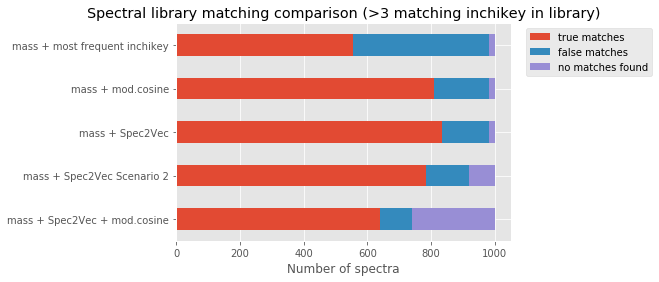

In [103]:
ylabels = ['mass + most frequent inchikey',
          'mass + mod.cosine', 
          'mass + Spec2Vec',
          'mass + Spec2Vec + mod.cosine',
          'mass + Spec2Vec Scenario 2']#,'mass + Spec2Vec + mod.cosine -> mass + Spec2Vec (2 steps)']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test0_arr == 1), np.sum(test0_arr == 0), np.sum(test0_arr == -1)],
                [np.sum(test1_arr == 1), np.sum(test1_arr == 0), np.sum(test1_arr == -1)],
               [np.sum(test2_arr == 1), np.sum(test2_arr == 0), np.sum(test2_arr == -1)],
               [np.sum(test3_arr == 1), np.sum(test3_arr == 0), np.sum(test3_arr == -1)],
                [np.sum(test4_arr == 1), np.sum(test4_arr == 0), np.sum(test4_arr == -1)]])
  
dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison (>3 matching inchikey in library)')

In [104]:
testLR_true_false = [] # linear regression
testML_true_false = []

for ID in range(len(spectra_unknown)):
    
    # Scenario ML - linear regression
    predictions = regressor.predict(found_matches[ID].drop(columns= ['spectra_ID', 'inchikey_match']))
    spectraIDs = found_matches[ID]['spectra_ID'][predictions.argmax()]
    #spectraIDs = found_matches[ID][IDs == 1]['spectra_ID'].values.tolist()
    inchikeys14 = library_spectra_metadata.iloc[spectraIDs]['inchikey'][:14]
    if len(inchikeys14) > 0:
        best_bet = 1 * (inchikeys14 == spectra_unknown[ID].inchikey[:14])        
    else:
        best_bet = -1 # meaning: not found

    testLR_true_false.append(best_bet)
    
    # Scenario ML - decision tree
    IDs = ML_model_DT.predict(found_matches[ID].drop(columns= ['spectra_ID', 'inchikey_match']))
    spectraIDs = found_matches[ID][IDs == 1]['spectra_ID'].values.tolist()
    inchikeys14 = pd.Series(library_spectra_metadata.iloc[spectraIDs]['inchikey'].str[:14])
    if inchikeys14.shape[0] > 0:
        best_bet = 1 * (inchikeys14.value_counts().index[0] == spectra_unknown[ID].inchikey[:14])        
    else:
        best_bet = -1 # meaning: not found

    testML_true_false.append(best_bet)
    
# Make arrays from lists:
testLR_arr = np.array(testLR_true_false)
testML_arr = np.array(testML_true_false)

In [105]:
print("Linear regression found matches:", np.sum(testLR_arr == 1), " --- nothing detected for: ", np.sum(testLR_arr == -1))
print("ML found matches:", np.sum(testML_arr == 1), " --- nothing detected for: ", np.sum(testML_arr == -1))

Linear regression found matches: 840  --- nothing detected for:  0
ML found matches: 618  --- nothing detected for:  67


Text(0.5, 1.0, 'Spectral library matching comparison (>3 matching inchikey in library)')

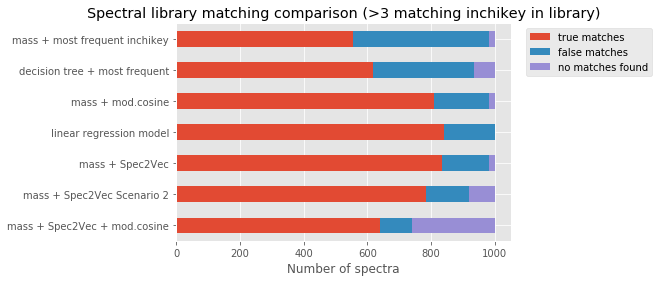

In [108]:
plt.style.use('ggplot')

ylabels = ['mass + most frequent inchikey',
          'mass + mod.cosine', 
          'mass + Spec2Vec',
          'mass + Spec2Vec + mod.cosine',
          'mass + Spec2Vec Scenario 2',
          'linear regression model',
          'decision tree + most frequent']
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test0_arr == 1), np.sum(test0_arr == 0), np.sum(test0_arr == -1)],
                [np.sum(test1_arr == 1), np.sum(test1_arr == 0), np.sum(test1_arr == -1)],
               [np.sum(test2_arr == 1), np.sum(test2_arr == 0), np.sum(test2_arr == -1)],
               [np.sum(test3_arr == 1), np.sum(test3_arr == 0), np.sum(test3_arr == -1)],
                [np.sum(test4_arr == 1), np.sum(test4_arr == 0), np.sum(test4_arr == -1)],
                 [np.sum(testLR_arr == 1), np.sum(testLR_arr == 0), np.sum(testLR_arr == -1)],
                 [np.sum(testML_arr == 1), np.sum(testML_arr == 0), np.sum(testML_arr == -1)]])
  
dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Spectral library matching comparison (>3 matching inchikey in library)')